In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
%matplotlib inline

In [2]:
clustered_masks_path = '/home/wences/Documents/GitRepos/FCNBudDetection/output/validation/0FCMN32rmsprop_lr0.0001_prep_mobilenet_ep150/clustered_masks/'
prediction_masks_path = '/home/wences/Documents/GitRepos/FCNBudDetection/output/validation/0FCMN32rmsprop_lr0.0001_prep_mobilenet_ep150/prediction_masks/'
source_images_path = '/home/wences/Documents/temp/dataset_resize/images_resize/'

In [3]:
per_sample_csv = pd.read_csv('metrics_cluster_0FCMN32rmsprop_lr0.0001_prep_mobilenet_ep150.csv')
ground_truth = pd.read_csv('single_instance_dataset_wradius.csv')
test_set_image_list = pd.read_csv('single_instance_test.csv')
test_set_image_list = test_set_image_list['imageOrigin'].values
ground_truth_test = ground_truth.loc[ground_truth['imageOrigin'].isin(test_set_image_list.tolist()), :]

### Breve descripcion de las distancias obtenidas a traves de todos los thresholds

In [4]:
per_sample_csv.columns

Index(['Unnamed: 0', 'model_name', 'threshold', 'mask_name', 'eps',
       'min_samples', 'buds_predicted', 'true_positive_x', 'true_positive_y',
       'true_positive_distance', 'true_positive_norm_distance'],
      dtype='object')

In [5]:
per_sample_csv['true_positive_distance'].describe()

count    987.000000
mean      21.138160
std       62.817056
min        0.202645
25%        2.793745
50%        4.899121
75%       12.715170
max      532.677380
Name: true_positive_distance, dtype: float64

### Promedio y desviacion estandard de a cada threshold

In [6]:
per_sample_csv.pivot_table(values='true_positive_distance',index='threshold', aggfunc=[np.std, np.mean])

,std,mean
,true_positive_distance,true_positive_distance
threshold,,
0.1,71.348505,24.886013
0.2,72.171967,24.730272
0.3,63.475700,21.486730
0.4,63.567102,21.581627
0.5,63.664989,21.665759
0.6,63.749156,21.733914
0.7,54.458536,18.119578
0.8,55.158537,17.817455


Donde caen las yemas en las escenas que conforman el dataset?

<Figure size 288x360 with 0 Axes>

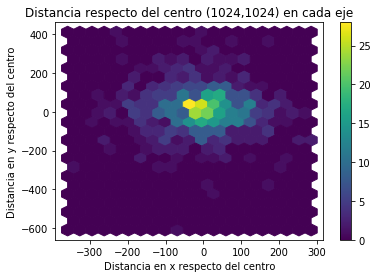

<Figure size 288x360 with 0 Axes>

In [7]:
plt.hexbin(x=ground_truth['x_center_resize'].values-1024,y=ground_truth['y_center_resize'].values-1024,gridsize=20)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.colorbar()
plt.figure(figsize=(4,5))

### Para el conjunto de testeo que pertenece al dataset:

In [8]:
ground_truth_test.columns

Index(['Unnamed: 0', 'imageOrigin', 'mask', 'patch_name', 'x_center_orig',
       'y_center_orig', 'x_center_resize', 'y_center_resize', 'diam_orig',
       'diam_resize'],
      dtype='object')

<Figure size 288x360 with 0 Axes>

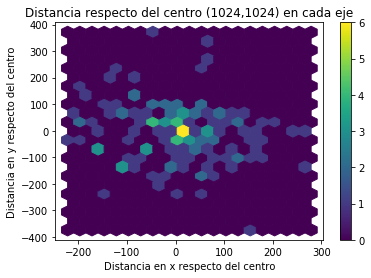

<Figure size 288x360 with 0 Axes>

In [9]:
plt.hexbin(x=ground_truth_test['x_center_resize'].values-1024,y=ground_truth_test['y_center_resize'].values-1024,gridsize=20)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.colorbar()
plt.figure(figsize=(4,5))

### Ahora como scatterplot

<Figure size 288x360 with 0 Axes>

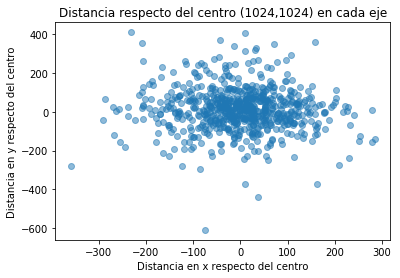

<Figure size 288x360 with 0 Axes>

In [10]:
plt.scatter(x=ground_truth['x_center_resize'].values-1024,y=ground_truth['y_center_resize'].values-1024, alpha=0.5)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.figure(figsize=(4,5))

### Para el conjunto de testeo que pertenece al dataset:

<Figure size 288x360 with 0 Axes>

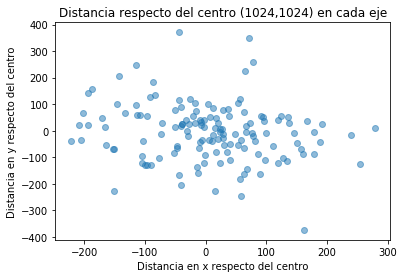

<Figure size 288x360 with 0 Axes>

In [11]:
plt.scatter(x=ground_truth_test['x_center_resize'].values-1024,y=ground_truth_test['y_center_resize'].values-1024, alpha=0.5)
plt.title('Distancia respecto del centro (1024,1024) en cada eje')
plt.ylabel('Distancia en y respecto del centro')
plt.xlabel('Distancia en x respecto del centro')
plt.figure(figsize=(4,5))

### Cual es el diametro promedio de las yemas del dataset. (Dividido por 2 ya que la red se entrena con 1024x1024 y este csv que describe el dataset esta en 2048x2048)

In [12]:
ground_truth['diam_resize'].describe()

count    698.000000
mean     247.287658
std      162.381768
min       31.614458
25%      131.415205
50%      202.195448
75%      306.377510
max      963.368421
Name: diam_resize, dtype: float64

### Para el conjunto de testeo que pertenece al dataset:

In [13]:
ground_truth_test['diam_resize'].describe()

count    140.000000
mean     227.442261
std      146.006064
min       50.506024
25%      124.810916
50%      178.042697
75%      286.672021
max      741.052632
Name: diam_resize, dtype: float64

### Ahora dividamos los resultados en rangos de distancia y veamos cuantos centros de yema caen en cada bolsa. (Veamos que tan dispersas son las predicciones del modelo en cuanto a distancia normalizada)

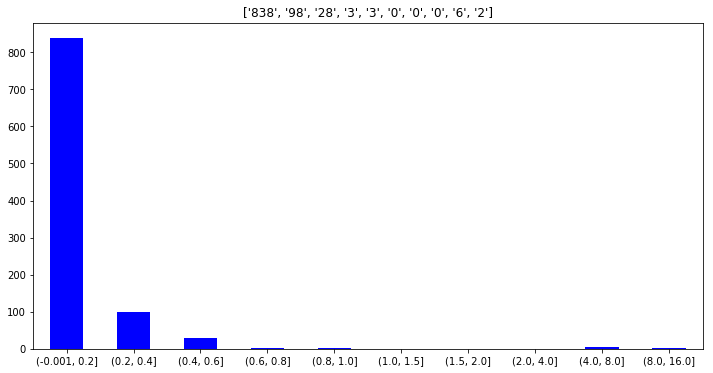

In [14]:
out = pd.cut(per_sample_csv['true_positive_norm_distance'].values, bins=[0,0.2,0.4,0.6,0.8,1,1.5,2,4,8,16], include_lowest=True)
out.value_counts().plot.bar(rot=0, color="b", figsize=(12,6))
plt.title([str(out.value_counts().values[i]) for i in range(out.value_counts().values.shape[0])]);

### Ahora dividamos los resultados en rangos de distancia y veamos cuantos centros de yema caen en cada bolsa. (Veamos que tan dispersas son las predicciones del modelo en cuanto a distancia normalizada)

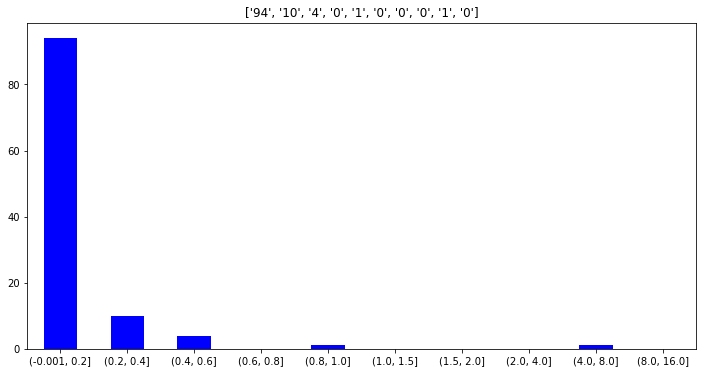

In [15]:
temp = per_sample_csv.loc[per_sample_csv['threshold'] == 0.5,:]
out = pd.cut(temp['true_positive_norm_distance'].values, bins=[0,0.2,0.4,0.6,0.8,1,1.5,2,4,8,16], include_lowest=True)
out.value_counts().plot.bar(rot=0, color="b", figsize=(12,6))
plt.title([str(out.value_counts().values[i]) for i in range(out.value_counts().values.shape[0])]);

### Numero de NaNs en todo el dataset y todos los thresholds, no yema detectada, imagen negra

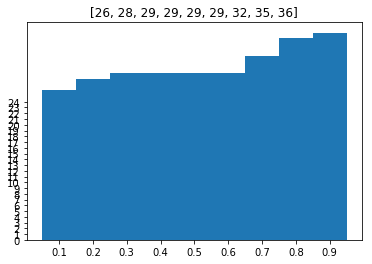

In [16]:
threshold_list = per_sample_csv['threshold'].unique()
nan_list = []
for threshold in threshold_list:
    th_df = per_sample_csv.loc[per_sample_csv['threshold'] == threshold,:]
    nan_list.append(th_df.loc[per_sample_csv['buds_predicted'] == 0,:].shape[0])
plt.bar(x=threshold_list, height=nan_list, align='center',tick_label=threshold_list,width=0.1, linewidth=2)
plt.yticks(np.arange(0,25,1))
plt.title(nan_list);

### Numero de clusteres detectados en la mascara generada

In [17]:
per_sample_csv.pivot_table(values='buds_predicted',index='threshold', aggfunc=[np.sum])

,sum
,buds_predicted
threshold,
0.1,125
0.2,120
0.3,118
0.4,118
0.5,118
0.6,117
0.7,112
0.8,110


### Visualizacion de 10 imagenes donde no se pudieron detectar yemas

In [18]:
w=10
h=10
columns = 4
rows = 5

In [19]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['buds_predicted'] == 0),:]
img_list = temp['mask_name'].values

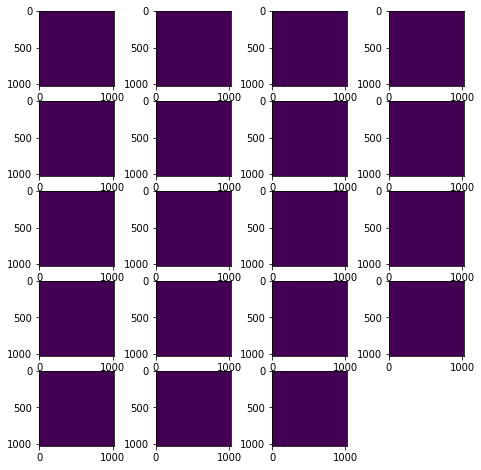

In [20]:
fig=plt.figure(figsize=(8, 8))
for i in range(1, columns*rows):
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i-1]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

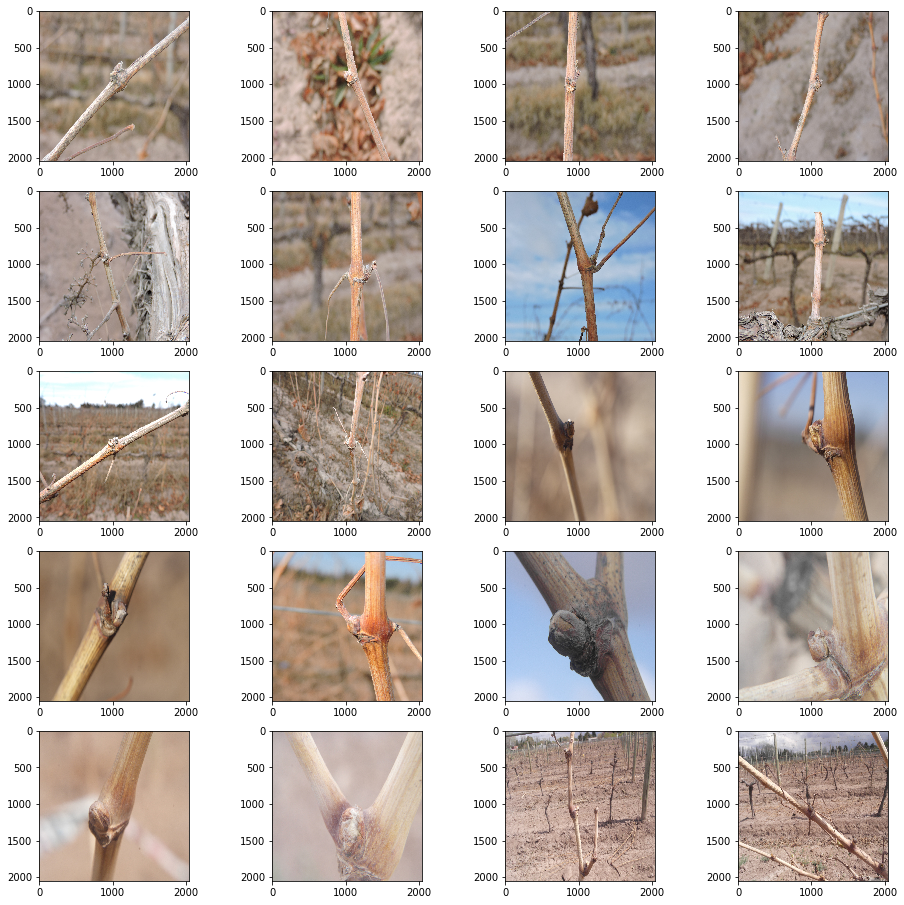

In [21]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

### Veamos las escenas con th 0.5 donde se detecto solo una yema

In [22]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['buds_predicted'] == 1),:]
img_list = temp['mask_name'].values

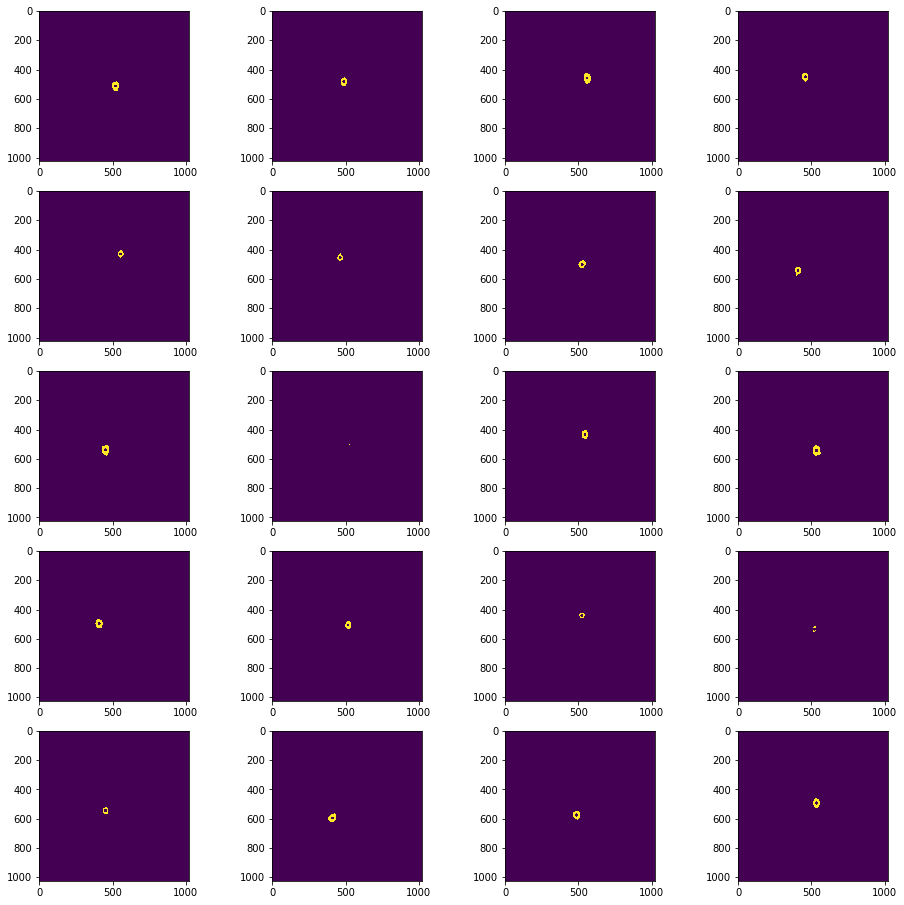

In [23]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i]))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(cv2.circle(img, center=center, radius=10, color=(0,0,0),thickness=-1))
plt.show()

Distancia en pixeles respecto de los centros gt y de su true positive, arriba de cada imagen 

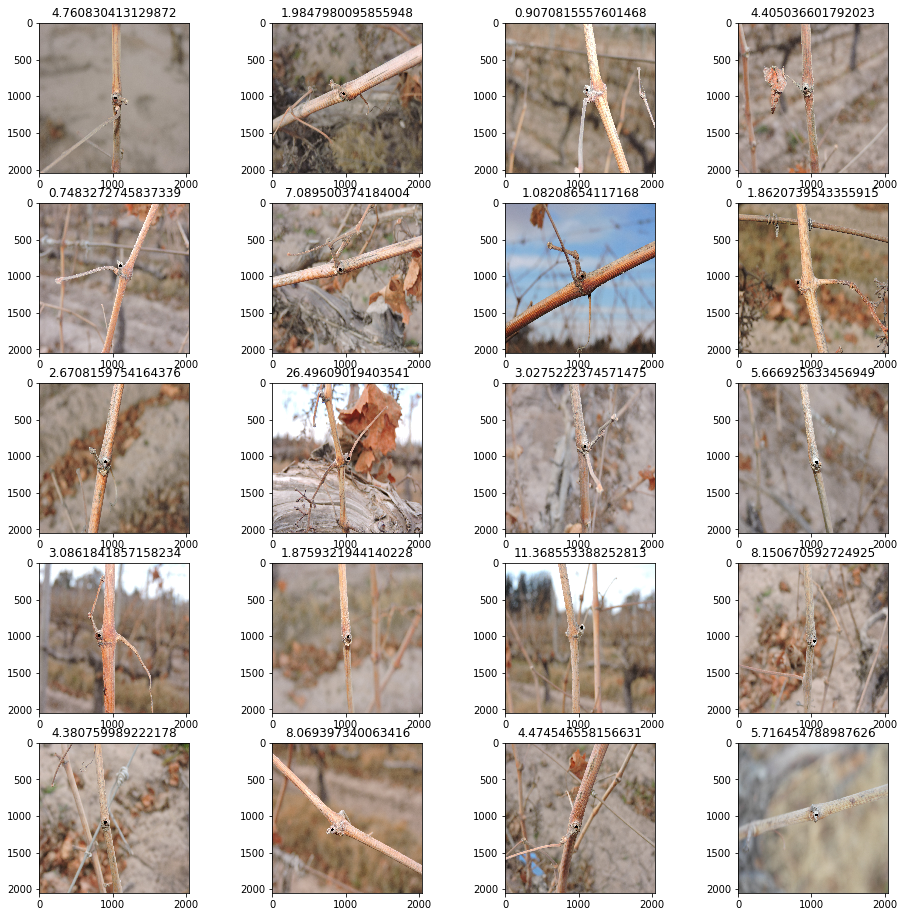

In [24]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=tuple([2*x for x in center]), radius=20, color=(0,0,0),thickness=-1))
plt.show()

### Veamos aquellas instancias sobre las que se detectaron varios clusters

In [25]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['buds_predicted'] >= 2),:]
img_list = temp['mask_name'].values

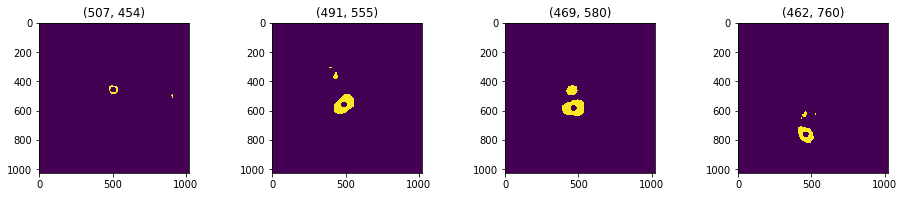

In [26]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, len(img_list)):
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i]))
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=center)
    plt.imshow(cv2.circle(img, center=center, radius=20, color=(0,0,0),thickness=-1))
plt.show()

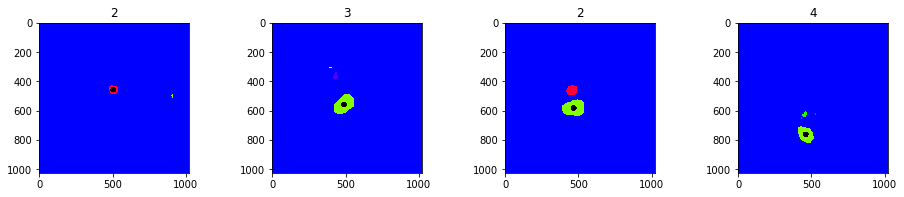

In [27]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, len(img_list)):
    img = plt.imread(os.path.join(clustered_masks_path,'cluster_'+img_list[i]))
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=20, color=(0,0,0),thickness=-1))
plt.show()

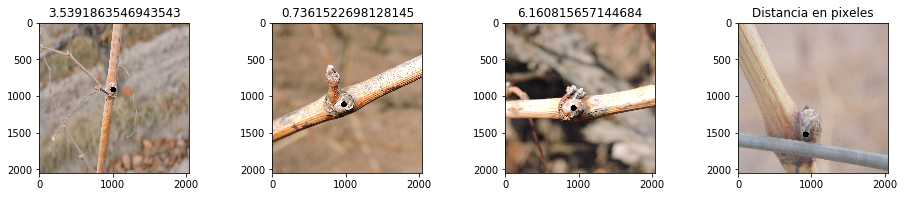

In [28]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, len(img_list)):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=tuple([2*x for x in center]), radius=40, color=(0,0,0),thickness=-1))
plt.title('Distancia en pixeles')
plt.show()

### Veamos los casos en los que la distancia euclideana normalizada fue mayor a un diametro de yema [th = 0.5]

In [29]:
temp = per_sample_csv.loc[(per_sample_csv['threshold'] == 0.5 )& (per_sample_csv['true_positive_norm_distance'] >= 1),:]
img_list = temp['mask_name'].values
temp.shape

(2, 11)

In [30]:
w=10
h=10
columns = 2
rows = 1

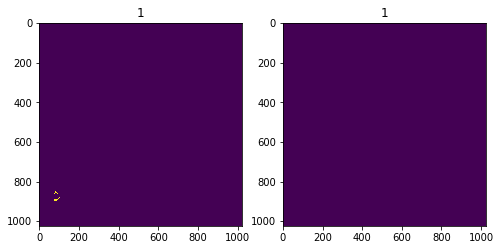

In [31]:
fig=plt.figure(figsize=(8, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = plt.imread(os.path.join(prediction_masks_path,img_list[i]))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=15, color=(0,0,0),thickness=-1))
plt.show()


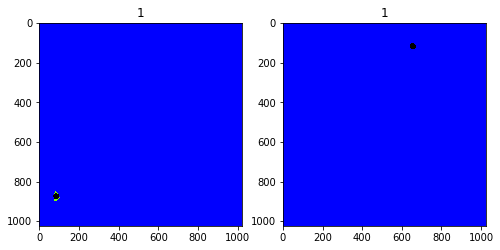

In [32]:
fig=plt.figure(figsize=(8, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = plt.imread(os.path.join(clustered_masks_path,'cluster_'+img_list[i]))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=15, color=(0,0,0),thickness=-1))
plt.show()

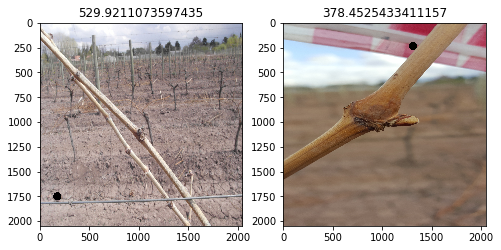

In [33]:
fig=plt.figure(figsize=(8, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][3:8] + 'jpg')), cv2.COLOR_BGR2RGB)
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=tuple([2*x for x in center]), radius=40, color=(0,0,0),thickness=-1))
plt.show()

### Creo que puede llegar a influir la distancia de la yema en la escena, es decir se comporta mejor para aquellos casos donde la yema es mas grande

### Resultado Precision y Recall  
-  Fijarse de que haya un threshold para true positives en distancia para que no queden clusters malisimos como tp


In [34]:
per_sample_csv.loc[per_sample_csv['threshold'] == 0.1,:]['buds_predicted'].sum()

125

[0.912,
 0.9333333333333333,
 0.940677966101695,
 0.940677966101695,
 0.940677966101695,
 0.9487179487179487,
 0.9642857142857143,
 0.9545454545454546,
 0.9811320754716981]

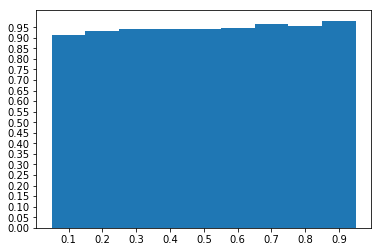

In [37]:
threshold_list = per_sample_csv['threshold'].unique()
prec_list = []
for threshold in threshold_list:
    th_df = per_sample_csv.loc[per_sample_csv['threshold'] == threshold,:]
    true_positives = th_df.loc[th_df['buds_predicted']>=1,:].shape[0]
    false_positives = th_df.loc[th_df['buds_predicted']>=1,:]['buds_predicted'].sum() - true_positives
    prec_list.append(true_positives / (true_positives + false_positives))
plt.bar(x=threshold_list, height=prec_list, align='center',tick_label=threshold_list,width=0.1, linewidth=2)
plt.yticks(np.arange(0,1,0.05));
(prec_list)

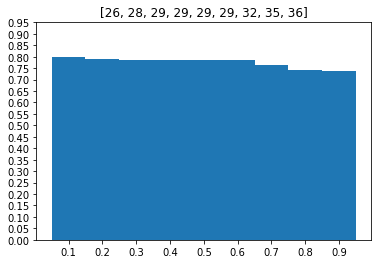

In [38]:
threshold_list = per_sample_csv['threshold'].unique()
rec_list = []
for threshold in threshold_list:
    th_df = per_sample_csv.loc[per_sample_csv['threshold'] == threshold,:]
    true_positives = th_df.loc[th_df['buds_predicted']==1,:].shape[0] #aquellos patches en los que se predijo una yema
    false_negatives = th_df.loc[th_df['buds_predicted']==0,:].shape[0] # aquellos en los que no se predijeron ninguna
    rec_list.append(true_positives / (true_positives + false_negatives))
plt.bar(x=threshold_list, height=rec_list, align='center',tick_label=threshold_list,width=0.1, linewidth=2)
plt.yticks(np.arange(0,1,0.05))
plt.title(nan_list);